In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 35.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드/test1.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드/train1.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203932 entries, 0 to 203931
Data columns (total 39 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   building_id        203932 non-null  int64  
 1   date               203932 non-null  object 
 2   temperature        203932 non-null  float64
 3   precipitation      203932 non-null  float64
 4   windspeed          203932 non-null  float64
 5   humidity           203932 non-null  float64
 6   sunshine_hours     203932 non-null  float64
 7   solar_radiation    203932 non-null  float64
 8   power_consumption  203932 non-null  float64
 9   building_type      203932 non-null  object 
 10  total_floor_area   203932 non-null  float64
 11  solar_capacity     203932 non-null  float64
 12  ess_capacity       203932 non-null  float64
 13  pcs_capacity       203932 non-null  float64
 14  hour               203932 non-null  int64  
 15  dow                203932 non-null  int64  
 16  mo

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['building_type_encoded'] = le.fit_transform(train['building_type'])
test['building_type_encoded'] = le.fit_transform(test['building_type'])

print("클래스 목록:", le.classes_)
print(train[['building_type', 'building_type_encoded']].head())

클래스 목록: ['IDC(전화국)' '건물기타' '공공' '백화점' '병원' '상용' '아파트' '연구소' '학교' '호텔']
  building_type  building_type_encoded
0            호텔                      9
1            호텔                      9
2            호텔                      9
3            호텔                      9
4            호텔                      9


# 모델링

In [5]:
X = train.drop(['solar_capacity', 'ess_capacity', 'pcs_capacity','building_type',
                'power_consumption','windspeed','precipitation','date'], axis =1 )

Y = train[['power_consumption', 'building_type_encoded']]

test_X = test.drop(['solar_capacity', 'ess_capacity', 'pcs_capacity','date','building_type',
                   'windspeed','precipitation', 'pred_solar_radiation', 'pred_sunshine_hours'], axis=1)

In [ ]:
'''
X = train.drop(['solar_capacity', 'ess_capacity', 'pcs_capacity',
                'power_consumption','building_type', 'windspeed',
                'date'], axis =1 )

Y = train[['building_type_encoded','power_consumption']]

test_X = test.drop(['solar_capacity', 'ess_capacity', 'pcs_capacity','date',
                   'building_type', 'windspeed','precipitation'], axis=1)
'''

KeyError: "['building_type_encoded'] not in index"

In [ ]:
cat_cols = ["building_type", "rain_bin", "wind_bin"]

for col in cat_cols:
    if col in X.columns:
        X[col] = X[col].astype("category").cat.codes
    if col in Y.columns:
        Y[col] = Y[col].astype("category").cat.codes
    if col in test_X.columns:
        test_X[col] = test_X[col].astype("category").cat.codes


## 유형별 모델 (building_type_encoded 별 KFold + XGBoost)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import lightgbm as lgb

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1e-8, denom)
    return np.mean(diff / denom) * 100.0

# LightGBM용 커스텀 feval: 로그 학습이므로 expm1로 원스케일 변환 후 SMAPE 계산
def feval_smape_log(y_pred_log, dtrain: lgb.Dataset):
    y_true_log = dtrain.get_label()
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return ('smape', smape(y_true, y_pred), False)  # 낮을수록 좋음(False)

KFOLD_SPLITS = 5
RANDOM_SEED  = 42
DATA_DIR     = "/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드"
target_col   = "power_consumption"

# 결과 그릇
type_list = X["building_type_encoded"].unique()
answer_df = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
pred_df   = pd.DataFrame(index=Y.index,     columns=["pred"],   dtype=float)

kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# 유형별 학습/예측
for btype in type_list:
    # 유형 필터
    x_all  = X[X['building_type_encoded'] == btype].copy()
    y_all  = Y[Y['building_type_encoded'] == btype][target_col].copy()
    xt_all = test_X[test_X['building_type_encoded'] == btype].copy()

    # building_id 원핫 (train+test 합쳐 동일화)
    join = pd.concat([x_all, xt_all], axis=0, copy=False)
    join = pd.get_dummies(join, columns=["building_id"], drop_first=False)

    x  = join.iloc[:len(x_all)].copy()
    xt = join.iloc[len(x_all):].copy()

    # 불필요 열 제거
    drop_cols = ["building_type_encoded"]
    x  = x.drop(columns=[c for c in drop_cols if c in x.columns])
    xt = xt.drop(columns=[c for c in drop_cols if c in xt.columns])

    preds_valid = pd.Series(index=y_all.index, dtype=float)
    preds_test_each_fold = []

    x_values = x.values
    y_values = y_all.values

    fold_scores = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
        X_tr, X_va = x_values[tr_idx], x_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]

        # 로그 변환
        y_tr_log = np.log1p(y_tr)
        y_va_log = np.log1p(y_va)

        # Dataset 구성
        dtrain = lgb.Dataset(X_tr, label=y_tr_log, free_raw_data=False)
        dvalid = lgb.Dataset(X_va, label=y_va_log, reference=dtrain, free_raw_data=False)

        params = {
            'objective': 'regression',     # 로그값 회귀
            'metric': 'rmse',              # 모니터링 메트릭(로그 스케일)
            'learning_rate': 0.05,
            'max_depth': 8,
            'num_leaves': 255,             # depth=8에 대략 호환
            'feature_fraction': 0.5,       # xgb의 colsample_bytree 유사
            'bagging_fraction': 0.7,       # xgb의 subsample 유사
            'bagging_freq': 1,
            'min_child_samples': 20,       # 필요시 3->20로 합리적 기본값
            'verbose': -1,
            'seed': RANDOM_SEED,
            'force_row_wise': True         # 큰/희소 행렬 안정성
        }

        # 학습 (조기종료 + 커스텀 SMAPE 함께)
        booster = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=5000,
            valid_sets=[dtrain, dvalid],
            valid_names=['train', 'valid'],
            feval=feval_smape_log,
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )

        # best_iteration 사용해 예측
        best_iter = booster.best_iteration if booster.best_iteration is not None else booster.current_iteration()
        va_pred_log = booster.predict(X_va, num_iteration=best_iter)
        va_pred = np.expm1(va_pred_log)

        preds_valid.loc[y_all.index[va_idx]] = va_pred
        fold_smape = smape(y_va, va_pred)
        fold_scores.append(fold_smape)

        # test 예측
        xt_pred_log = booster.predict(xt.values, num_iteration=best_iter)
        xt_pred = np.expm1(xt_pred_log)
        preds_test_each_fold.append(xt_pred)

    # fold 평균으로 test 예측
    xt_mean_pred = np.mean(preds_test_each_fold, axis=0)

    # 적재
    pred_df.loc[preds_valid.index, "pred"] = preds_valid
    answer_df.loc[xt_all.index,     "answer"] = xt_mean_pred

    print(f"[{btype}] = {np.mean(fold_scores):.4f}")

# 전체 성능
total_smape = smape(
    Y.sort_index()[target_col].values,
    pred_df.sort_index()["pred"].values
)
print(f"Total SMAPE = {total_smape:.4f}")


[9] = 4.9139
[5] = 2.2806
[4] = 2.4858
[8] = 2.5477
[1] = 4.2813
[6] = 3.0776
[7] = 3.7426
[3] = 4.5751
[0] = 1.3564
[2] = 5.2847
Total SMAPE = 3.5169


## 건물별 모델 (building_id 단위 KFold + XGBoost)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import lightgbm as lgb

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1e-8, denom)
    return np.mean(diff / denom) * 100.0

def predict_with_best_iter_lgb(booster: lgb.Booster, X_array):
    """LightGBM 버전 차이를 고려해 best_iteration을 안전하게 사용."""
    best_iter = getattr(booster, "best_iteration", None)
    if best_iter is None:
        # 일부 버전에서는 current_iteration() 제공
        try:
            best_iter = booster.current_iteration()
        except Exception:
            best_iter = None
    # num_iteration=None이면 전체 트리 사용
    return booster.predict(X_array, num_iteration=best_iter)

RANDOM_SEED  = globals().get('RANDOM_SEED', 42)
DATA_DIR     = globals().get('DATA_DIR', "/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드")
KFOLD_SPLITS = globals().get('KFOLD_SPLITS', 5)

id_col     = 'building_id'
type_col   = 'building_type'
target_col = 'power_consumption'

def ensure_numeric(df, drop_cols=None):
    df = df.copy()
    if drop_cols:
        df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    for c in df.columns:
        if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_string_dtype(df[c]):
            df[c] = df[c].astype('category').cat.codes
    return df

drop_never = ['date']

# 원본 보존을 위해 사본 생성
X_num      = ensure_numeric(X, drop_cols=drop_never)
test_X_num = ensure_numeric(test_X, drop_cols=drop_never)

# 결과
answer_df_by_building = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
pred_df_by_building   = pd.DataFrame(index=X.index,       columns=["pred"],   dtype=float)

building_numbers = X_num[id_col].unique()

for bnum in building_numbers:
    # 필터
    x_b  = X_num[X_num[id_col] == bnum].copy()
    y_b  = train[train[id_col] == bnum][target_col].copy()
    xt_b = test_X_num[test_X_num[id_col] == bnum].copy()

    # 표본 체크
    n_samples = len(x_b)
    if n_samples < 2 or len(y_b) < 2:
        print(f"[SKIP] Building {bnum}: too few samples (n={n_samples}).")
        continue

    # 드롭: id/타입 등 모델 입력 제외
    drop_cols = [id_col, type_col]
    x_b  = x_b.drop(columns=[c for c in drop_cols if c in x_b.columns], errors='ignore')
    xt_b = xt_b.drop(columns=[c for c in drop_cols if c in xt_b.columns], errors='ignore')

    # train/test 컬럼 일치
    xt_b = xt_b.reindex(columns=x_b.columns, fill_value=0)

    # KFold 분할 수 안전 조정
    n_splits = min(KFOLD_SPLITS, n_samples)
    if n_splits < 2:
        print(f"[SKIP] Building {bnum}: not enough data for KFold (n={n_samples}).")
        continue
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    preds_valid_b = pd.Series(index=y_b.index, dtype=float)
    preds_test_b_each_fold = []

    X_values = x_b.values
    y_values = y_b.values

    fold_scores = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_values), 1):
        X_tr, X_va = X_values[tr_idx], X_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]

        # 로그변환
        y_tr_log = np.log1p(y_tr)
        y_va_log = np.log1p(y_va)

        # LightGBM Dataset
        dtrain = lgb.Dataset(X_tr, label=y_tr_log, free_raw_data=False)
        dvalid = lgb.Dataset(X_va, label=y_va_log, reference=dtrain, free_raw_data=False)

        params = {
            'objective': 'regression',      # 로그 스케일 회귀
            'metric': 'rmse',               # 모니터링 메트릭(로그 스케일)
            'learning_rate': 0.05,
            'max_depth': 8,
            'num_leaves': 255,              # depth=8 대략 대응
            'feature_fraction': 0.5,        # colsample_bytree 유사
            'bagging_fraction': 0.7,        # subsample 유사
            'bagging_freq': 1,
            'min_child_samples': 20,        # 합리적 기본값
            'min_sum_hessian_in_leaf': 1e-3,
            'seed': RANDOM_SEED,
            'verbose': -1,
            'force_row_wise': True
        }

        booster = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=5000,
            valid_sets=[dtrain, dvalid],
            valid_names=['train', 'valid'],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )

        # best iteration 예측
        va_pred_log = predict_with_best_iter_lgb(booster, X_va)
        va_pred     = np.expm1(va_pred_log)

        preds_valid_b.loc[y_b.index[va_idx]] = va_pred
        fold_scores.append(smape(y_va, va_pred))

        # test 예측
        xt_pred_log = predict_with_best_iter_lgb(booster, xt_b.values)
        xt_pred     = np.expm1(xt_pred_log)
        preds_test_b_each_fold.append(xt_pred)

    # fold 평균으로 test 예측
    xt_mean = np.mean(preds_test_b_each_fold, axis=0)

    # 결과 적재
    pred_df_by_building.loc[preds_valid_b.index, "pred"] = preds_valid_b
    answer_df_by_building.loc[xt_b.index, "answer"] = xt_mean

    print(f"Building {bnum} | LGBM SMAPE(mean folds): {np.mean(fold_scores):.4f}")

# 전체 성능
total_smape_by_building = smape(
    train.sort_index()[target_col].values,
    pred_df_by_building.sort_index()["pred"].values
)
print(f"Total SMAPE (by Building) = {total_smape_by_building:.4f}")


Building 1 | LGBM SMAPE(mean folds): 7.1768
Building 2 | LGBM SMAPE(mean folds): 4.8987
Building 3 | LGBM SMAPE(mean folds): 1.8889
Building 4 | LGBM SMAPE(mean folds): 4.3884
Building 5 | LGBM SMAPE(mean folds): 1.4236
Building 6 | LGBM SMAPE(mean folds): 5.8970
Building 7 | LGBM SMAPE(mean folds): 5.8298
Building 8 | LGBM SMAPE(mean folds): 3.3633
Building 9 | LGBM SMAPE(mean folds): 4.3119
Building 10 | LGBM SMAPE(mean folds): 4.0244
Building 11 | LGBM SMAPE(mean folds): 2.1687
Building 12 | LGBM SMAPE(mean folds): 1.7359
Building 13 | LGBM SMAPE(mean folds): 2.7514
Building 14 | LGBM SMAPE(mean folds): 1.7790
Building 15 | LGBM SMAPE(mean folds): 3.0178
Building 16 | LGBM SMAPE(mean folds): 1.8768
Building 17 | LGBM SMAPE(mean folds): 2.0887
Building 18 | LGBM SMAPE(mean folds): 3.4275
Building 19 | LGBM SMAPE(mean folds): 5.5867
Building 20 | LGBM SMAPE(mean folds): 0.8584
Building 21 | LGBM SMAPE(mean folds): 1.4844
Building 22 | LGBM SMAPE(mean folds): 2.5115
Building 23 | LGBM 

## 글로벌 모델 (전체 데이터 한 번에 KFold + XGBoost)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import lightgbm as lgb

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1e-8, denom)
    return np.mean(diff / denom) * 100.0

def predict_with_best_iter_lgb(booster: lgb.Booster, X_array):
    """LightGBM 버전 차이를 고려해 best_iteration을 안전하게 사용."""
    best_iter = getattr(booster, "best_iteration", None)
    if best_iter is None:
        try:
            best_iter = booster.current_iteration()
        except Exception:
            best_iter = None
    return booster.predict(X_array, num_iteration=best_iter)

def ensure_all_numeric(df):
    df = df.copy()
    for c in df.columns:
        if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_string_dtype(df[c]):
            df[c] = df[c].astype('category').cat.codes
    return df

RANDOM_SEED  = globals().get('RANDOM_SEED', 42)
DATA_DIR     = globals().get('DATA_DIR', "/content/drive/MyDrive/Colab Notebooks/DScover 25-2/25-2 가이드")
KFOLD_SPLITS = globals().get('KFOLD_SPLITS', 5)

# 어떤 ID 컬럼이 있는지 확인
id_cols_candidates = ["building_number", "building_id"]
id_col = next((c for c in id_cols_candidates if c in X.columns), None)

# 타입 컬럼도 있으면 사용
type_col = "building_type" if "building_type" in X.columns else None
target_col = "power_consumption"

# 원-핫
x_global  = X.copy()
xt_global = test_X.copy()

# building_type 더미 (있을 때만)
if type_col is not None:
    x_global  = pd.get_dummies(x_global,  columns=[type_col], drop_first=False)
    xt_global = pd.get_dummies(xt_global, columns=[type_col], drop_first=False)

# building id 더미 (있을 때만)
if id_col is not None:
    x_global  = pd.get_dummies(x_global,  columns=[id_col], drop_first=False)
    xt_global = pd.get_dummies(xt_global, columns=[id_col], drop_first=False)

# 사용하지 않을 열 제거
drop_cols_global = ['date']
x_global  = x_global.drop(columns=[c for c in drop_cols_global if c in x_global.columns], errors='ignore')
xt_global = xt_global.drop(columns=[c for c in drop_cols_global if c in xt_global.columns], errors='ignore')

# train/test 컬럼 일치
xt_global = xt_global.reindex(columns=x_global.columns, fill_value=0)

# 남은 문자열/객체 열 숫자화
x_global  = ensure_all_numeric(x_global)
xt_global = ensure_all_numeric(xt_global)

# 타깃 정렬 (X와 같은 인덱스 순서)
y_global = train.loc[X.index, target_col].astype(float).copy()

# 결과
answer_df_global = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
pred_df_global   = pd.DataFrame(index=X.index,       columns=["pred"],   dtype=float)

preds_valid_global = pd.Series(index=y_global.index, dtype=float)
preds_test_global  = []

# KFold
n_samples = len(x_global)
n_splits  = min(KFOLD_SPLITS, n_samples)
if n_splits < 2:
    raise ValueError(f"Not enough samples for KFold: n={n_samples}")
kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

x_values_global = x_global.values
y_values_global = y_global.values

fold_scores_global = []

for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values_global), 1):
    X_tr, X_va = x_values_global[tr_idx], x_values_global[va_idx]
    y_tr, y_va = y_values_global[tr_idx], y_values_global[va_idx]

    # 로그 변환
    y_tr_log = np.log1p(y_tr)
    y_va_log = np.log1p(y_va)

    # LightGBM Dataset
    dtrain = lgb.Dataset(X_tr, label=y_tr_log, free_raw_data=False)
    dvalid = lgb.Dataset(X_va, label=y_va_log, reference=dtrain, free_raw_data=False)

    params = {
        'objective': 'regression',   # 로그 스케일 회귀
        'metric': 'rmse',            # 모니터링 메트릭(로그 스케일)
        'learning_rate': 0.05,
        'max_depth': 10,             # XGB 설정을 반영
        'num_leaves': 2**10 - 1,     # depth~10에 대응 (대략 1023)
        'feature_fraction': 0.5,     # colsample_bytree 유사
        'bagging_fraction': 0.7,     # subsample 유사
        'bagging_freq': 1,
        'min_child_samples': 20,     # 합리적 기본값
        'min_sum_hessian_in_leaf': 1e-3,
        'seed': RANDOM_SEED,
        'verbose': -1,
        'force_row_wise': True
    }

    booster = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=5000,
        valid_sets=[dtrain, dvalid],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )

    # 검증 예측
    va_pred_log = predict_with_best_iter_lgb(booster, X_va)
    va_pred     = np.expm1(va_pred_log)
    preds_valid_global.iloc[va_idx] = va_pred
    fold_scores_global.append(smape(y_va, va_pred))

    # 테스트 예측
    xt_pred_log = predict_with_best_iter_lgb(booster, xt_global.values)
    xt_pred     = np.expm1(xt_pred_log)
    preds_test_global.append(xt_pred)

# fold 평균으로 test 예측/적재
answer_df_global.loc[xt_global.index, "answer"] = np.mean(preds_test_global, axis=0)
pred_df_global.loc[preds_valid_global.index, "pred"] = preds_valid_global

print(f"Global Model : LGBM SMAPE = {np.mean(fold_scores_global):.4f}")

total_smape_global = smape(
    train.sort_index()[target_col].values,
    pred_df_global.sort_index()["pred"].values
)
print(f"Total SMAPE (Global) = {total_smape_global:.4f}")


Global Model : LGBM SMAPE = 3.5004
Total SMAPE (Global) = 3.5004


# 파일 합치기

In [ ]:
# 각 모델별 파일 생성
pred_df.to_csv(f'{DATA_DIR}/pred_valid_lgbm.csv', index=False)
answer_df.to_csv(f'{DATA_DIR}/answer_test_lgbm.csv', index=False)

pred_df_by_building.to_csv(f'{DATA_DIR}/pred_valid_building_lgbm.csv', index=False)
answer_df_by_building.to_csv(f'{DATA_DIR}/answer_test_building_lgbm.csv', index=False)

pred_df_global.to_csv(f'{DATA_DIR}/pred_valid_global_lgbm.csv', index=False)
answer_df_global.to_csv(f'{DATA_DIR}/answer_test_global_lgbm.csv', index=False)

In [ ]:
# 파일 합치기

answer_df = pd.read_csv(f'{DATA_DIR}/answer_test_lgbm.csv')
answer_df_by_building = pd.read_csv(f'{DATA_DIR}/answer_test_building_lgbm.csv')
answer_df_global = pd.read_csv(f'{DATA_DIR}/answer_test_global_lgbm.csv')

final_ensemble_test_pred = (
    answer_df.sort_index()["answer"].values * 1/3 +
    answer_df_by_building.sort_index()["answer"].values * 1/3 +
    answer_df_global.sort_index()["answer"].values * 1/3
)

In [ ]:
final_ensemble_test_pred_fixed = [max(0, x) for x in final_ensemble_test_pred]
submission = pd.read_csv(f'{DATA_DIR}/sample_submission (1).csv')
submission['answer'] = final_ensemble_test_pred_fixed
submission.to_csv(f'{DATA_DIR}/submission_lgbm.csv', index=False)

# Feature importance


In [7]:
# ===== LGBM Refit + Importances + Permutation (SMAPE) + SHAP + Save =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt, lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from joblib import dump

# ---------- 0) 데이터 준비 (x_global/y_global 없으면 X/train로부터 생성) ----------
target_col = globals().get("target_col", "power_consumption")

def ensure_all_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_string_dtype(df[c]):
            df[c] = df[c].astype("category").cat.codes
    return df

if "x_global" in globals() and "y_global" in globals():
    X = x_global.copy()
    y = y_global.copy()
else:
    assert "X" in globals() and "train" in globals(), "X와 train이 필요합니다."
    df = X.copy()
    # 원핫 (존재하는 열만)
    for c in ["building_type", "building_id", "building_number"]:
        if c in df.columns:
            df = pd.get_dummies(df, columns=[c], drop_first=False)
    # 불필요 컬럼 제거
    if "date" in df.columns:
        df = df.drop(columns=["date"])
    # 숫자화
    df = ensure_all_numeric(df)
    # 타깃 정렬
    if target_col in train.columns:
        y = train.loc[df.index, target_col].astype(float)
    else:
        raise ValueError(f"train에 '{target_col}' 컬럼이 없습니다.")
    X = df

print(f"[info] X shape={X.shape}, y len={len(y)}")

# ---------- 1) LGBM 재학습 (로그 타깃) ----------
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_tr_log, y_val_log = np.log1p(y_tr), np.log1p(y_val)

lgb_params = dict(
    objective="regression",
    learning_rate=0.05,
    n_estimators=5000,      # early stopping으로 실제 트리 수 결정
    max_depth=10,
    num_leaves=2**10 - 1,
    subsample=0.7,          # bagging_fraction
    colsample_bytree=0.5,   # feature_fraction
    min_child_samples=20,
    random_state=42,
    n_jobs=-1
)
model = lgb.LGBMRegressor(**lgb_params)
model.fit(
    X_tr, y_tr_log,
    eval_set=[(X_val, y_val_log)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(100, verbose=False)]
)
booster = model.booster_
feat_names = X.columns.to_list()




스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

== LGBM Feature Importance (gain, Top-30) ==
day_hour_mean            952611.085814
hour_mean                341605.536328
hour_std                 292270.524334
day_hour_std             122798.277936
total_floor_area          46185.382987
building_type_encoded     42458.072458
cooling_ratio             13291.137794
sin_date                  13273.402191
has_pv                    11646.971892
building_id_81             6720.407803
cos_date                   6476.971581
building_id_36             3912.319914
building_id_43             3552.333945
day                        3158.109347
dow                        2817.339125
building_id_64             2764.242747
sin_month                  2533.763831
building_id_52             2349.400526
hour                       2231.981212
building_id_30             1999.163603
temperature                1996.290875
building_id_2              1904.236908
CDH                        1896.263332
THI                        1876.008826
building_id_35     

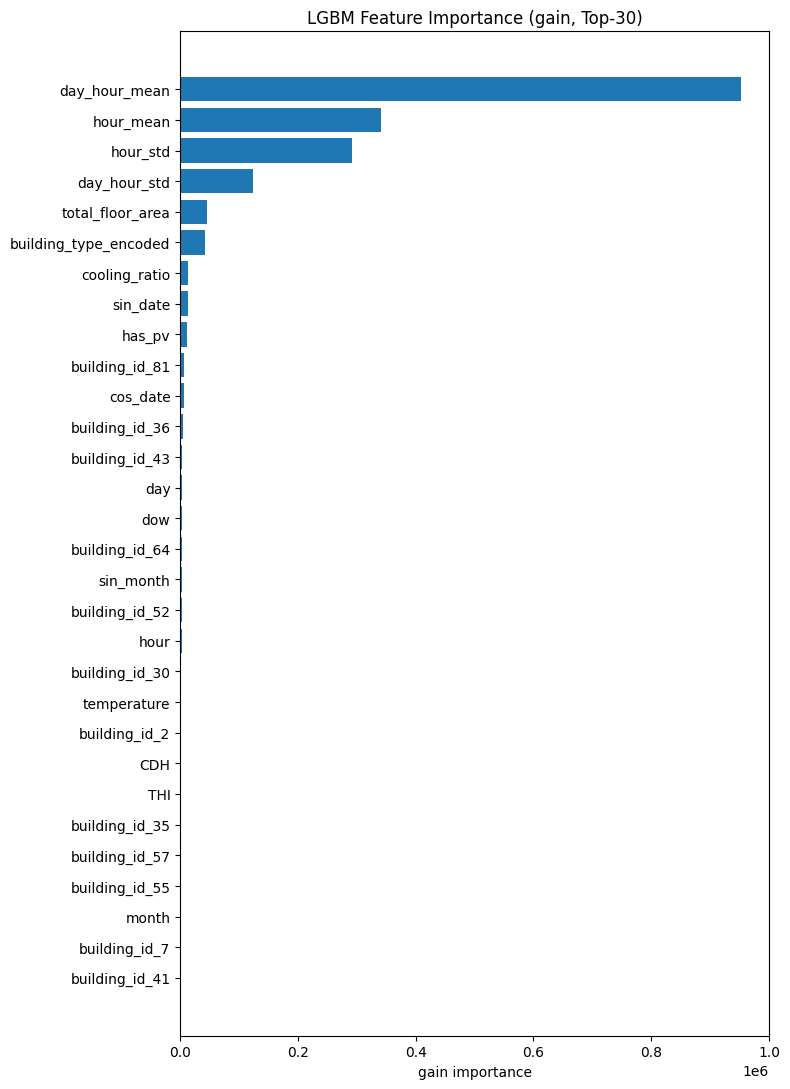

KeyboardInterrupt: 

In [8]:
# ---------- 2) LGBM 중요도 (split / gain) ----------
imp_split = pd.Series(booster.feature_importance("split"), index=feat_names, name="split").sort_values(ascending=False)
imp_gain  = pd.Series(booster.feature_importance("gain"),  index=feat_names, name="gain").sort_values(ascending=False)

print("== LGBM Feature Importance (gain, Top-30) ==")
print(imp_gain.head(30))

topN = 30
plt.figure(figsize=(8, min(12, 0.3*topN+2)))
plt.barh(imp_gain.head(topN)[::-1].index, imp_gain.head(topN)[::-1].values)
plt.xlabel("gain importance"); plt.title(f"LGBM Feature Importance (gain, Top-{topN})")
plt.tight_layout(); plt.show()

# ---------- 3) 퍼뮤테이션 중요도 (검증셋 SMAPE 기준) ----------
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_true - y_pred)
    denom = np.where(denom == 0, 1e-8, denom)
    return np.mean(diff / denom) * 100.0

def smape_from_log(y_true, y_pred_log):
    return smape(y_true, np.expm1(y_pred_log))

from sklearn.metrics import make_scorer
smape_scorer = make_scorer(smape_from_log, greater_is_better=False)

perm = permutation_importance(
    model, X_val, y_val, scoring=smape_scorer,
    n_repeats=10, n_jobs=-1, random_state=42
)
perm_df = pd.Series(perm.importances_mean, index=feat_names).sort_values(ascending=False)
print("\n== Permutation Importance (SMAPE drop, Top-30) ==")
print(perm_df.head(30))

plt.figure(figsize=(8, min(12, 0.3*topN+2)))
plt.barh(perm_df.head(topN)[::-1].index, perm_df.head(topN)[::-1].values)
plt.xlabel("SMAPE drop when permuted (higher = more important)")
plt.title(f"Permutation Importance (Top-{topN})")
plt.tight_layout(); plt.show()

